In [1]:
import json
import sys
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger
from s4hci.utils.frame_selection import mse_frame_selection, \
    shift_frame_selection

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

# Load the data

In [2]:
# 2.) Load the dataset
print_message("Loading dataset")
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",  #13_object_final
        psf_template_tag="psf_template", #10_psf
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [3]:
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_0105c.json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# All files we need

In [4]:
data_with_fake_planet_cut = data_with_fake_planet[:, 30:-30, 30:-30]
science_cut = science_data[:, 30:-30, 30:-30]

In [5]:
science_cut.shape

(57961, 57, 57)

# Train test split

In [6]:
w_planet_train = data_with_fake_planet_cut[:25000]
w_planet_test = data_with_fake_planet_cut[25000:]
n_planet_train = science_cut[:25000]
n_planet_test = science_cut[25000:]

In [7]:
train_angles = raw_angles[:25000]
test_angles = raw_angles[25000:]

# Run S4 raw on cut image (with fake planet)

In [16]:
s4_model_w_p = S4(
    science_data=w_planet_train,
    parang=train_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/split_in_half",
    convolve=True,
    verbose=True)

s4_model_w_p.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:28<00:00, 36.70it/s]


[DONE]
[DONE]
[DONE]


In [17]:
s4_model_n_p = S4(
    science_data=n_planet_train,
    parang=train_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/split_in_half",
    convolve=True,
    verbose=True)

s4_model_n_p.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:28<00:00, 36.78it/s]


[DONE]
[DONE]
[DONE]


In [23]:
model = s4_model_w_p
model.science_data = torch.from_numpy(n_planet_train).float()
model.parang = torch.from_numpy(train_angles).float()
residual_w_planet_train = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model = s4_model_n_p
model.science_data = torch.from_numpy(n_planet_train).float()
model.parang = torch.from_numpy(train_angles).float()
residual_n_planet_train = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model = s4_model_w_p
model.science_data = torch.from_numpy(n_planet_test).float()
model.parang = torch.from_numpy(test_angles).float()
residual_w_planet_test = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model = s4_model_n_p
model.science_data = torch.from_numpy(n_planet_test).float()
model.parang = torch.from_numpy(test_angles).float()
residual_n_planet_test = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]


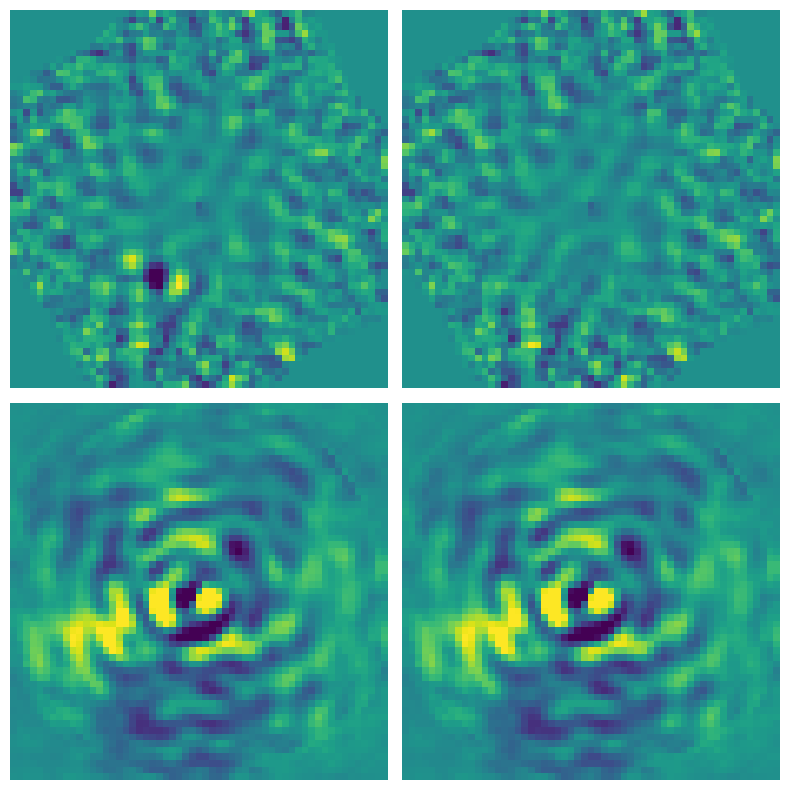

In [24]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

ax1.imshow(residual_w_planet_train, origin="lower", vmin=-0.02, vmax=0.02)
ax2.imshow(residual_n_planet_train, origin="lower", vmin=-0.02, vmax=0.02)
ax4.imshow(residual_w_planet_test, origin="lower", vmin=-0.2, vmax=0.2)
ax3.imshow(residual_n_planet_test, origin="lower", vmin=-0.2, vmax=0.2)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
plt.tight_layout()

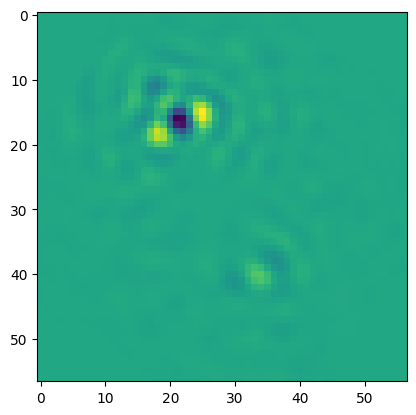

In [25]:
plt.imshow(residual_w_planet_train-residual_n_planet_train)

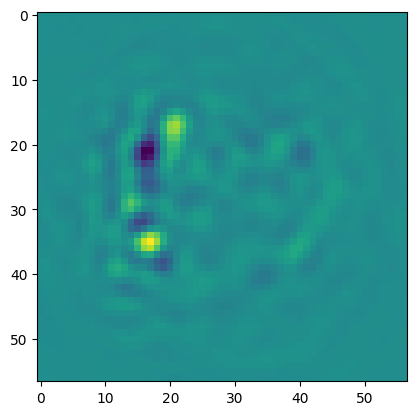

In [26]:
plt.imshow(residual_w_planet_test-residual_n_planet_test)